# State Farm Distracted Driver

## Configure training and test data


In [1]:
# Make sure we are starting in the right directory
%pwd

u'/home/ubuntu/nbs/hw1'

In [2]:
# Move data
import os, sys
current_dir = os.getcwd()
HOME_DIR = current_dir
DATA_HOME = HOME_DIR + '/data/state'

In [18]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))

#import modules
%matplotlib inline
from vgg16 import Vgg16
import utils

from keras.layers.core import Dense
from keras.optimizers import SGD, RMSprop, Adam

In [ ]:
%mkdir -p $DATA_HOME
%cp /home/ubuntu/downloads/state-farm/driver_imgs_list.csv $DATA_HOME
%cp -R /home/ubuntu/downloads/state-farm/test/ $DATA_HOME
%cp -R /home/ubuntu/downloads/state-farm/train/ $DATA_HOME

## Action Plan
1. Create validation and sample datasets
2. Train VGG16 model
3. Verify on sample data
4. Run through tests

In [9]:
%cd $DATA_HOME
%mkdir -p valid
%mkdir -p results
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

/home/ubuntu/nbs/hw1/data/state


In [4]:
from glob import glob
from shutil import copyfile
import numpy as np

In [5]:
%cd $DATA_HOME/train

/home/ubuntu/nbs/hw1/data/state/train


In [25]:
# Create validation set
curdir = os.getcwd()
for i in range(10):
    class_folder = 'c' + str(i) + '/'
    valid_folder = DATA_HOME + '/valid/' + class_folder
    os.chdir(curdir + '/' + class_folder)
    os.mkdir(valid_folder)
    g = glob('*.jpg')
    shuf = np.random.permutation(g)
    for i in range(200): os.rename(shuf[i], valid_folder + shuf[i])

In [34]:
%cd $DATA_HOME/train

/home/ubuntu/nbs/hw1/data/state/train


In [35]:
# Create sample set
curdir = os.getcwd()
for i in range(10):
    class_folder = 'c' + str(i) + '/'
    sample_folder = DATA_HOME + '/sample/train/' + class_folder
    os.chdir(curdir + '/' + class_folder)
    os.mkdir(sample_folder)
    g = glob('*.jpg')
    shuf = np.random.permutation(g)
    for i in range(20): copyfile(shuf[i], sample_folder + shuf[i])

In [36]:
%cd $DATA_HOME/valid

/home/ubuntu/nbs/hw1/data/state/valid


In [37]:
# Create sample set
curdir = os.getcwd()
for i in range(10):
    class_folder = 'c' + str(i) + '/'
    sample_folder = DATA_HOME + '/sample/valid/' + class_folder
    os.chdir(curdir + '/' + class_folder)
    os.mkdir(sample_folder)
    g = glob('*.jpg')
    shuf = np.random.permutation(g)
    for i in range(10): copyfile(shuf[i], sample_folder + shuf[i])

In [57]:
%cd $DATA_HOME/test/unknown
%mkdir $DATA_HOME/sample/test/unknown
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(10): copyfile(shuf[i], DATA_HOME + '/sample/test/unknown/' + shuf[i])

/home/ubuntu/nbs/hw1/data/state/test/unknown


In [39]:
# Create single 'unknown' class for test set
%cd $DATA_HOME/test
%mv *.jpg unknown/

/home/ubuntu/nbs/hw1/data/state/test


The data is already separated into the `c0` - `c10` class. Just need to train on these

In [5]:
%cd $DATA_HOME

train_path = DATA_HOME + '/sample/train/'
valid_path = DATA_HOME + '/sample/valid/'
test_path = DATA_HOME + '/sample/test/'
#train_path = DATA_HOME + 'train/'
#valid_path = DATA_HOME + '/valid/'
#test_path = DATA_HOME + '/test/'
results_path = DATA_HOME + '/results/'

/home/ubuntu/nbs/hw1/data/state


## Finetuning

In [38]:
vgg = Vgg16()

In [39]:
batch_size = 64
num_epochs = 1

In [40]:
finetune_own_code = False

batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size)

# Finetune batches - using utils.py
if not finetune_own_code:
    vgg.finetune(batches)
else:  # Finetune batches - my code using Keras
    model = vgg.model
    model.pop() # Remove last layer
    
    # don't re-train existing layers (since we only want to train the new last layer)
    for layer in model.layers:
        layer.trainable = False
    model.add(Dense(batches.nb_class, activation='softmax'))
    
    lr = 0.01
    model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    
    vgg.model = model
    

Found 200 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


In [46]:
# Fit the data and validate against valid set
for epoch in range(num_epochs):
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_wieights_filename = 'ft_weights%d.h5' % epoch
    vgg.model.save_weights(results_path + latest_wieights_filename)
print 'Successfully ran %d epochs' % num_epochs

Epoch 1/1
200/200 [==============================] - 79s - loss: 10.4336 - acc: 0.1900 - val_loss: 9.5320 - val_acc: 0.1300
Successfully ran 1 epochs


## Check Results

In [49]:
# Check a few results
test_batches, preds = vgg.test(test_path, batch_size=batch_size*2)

Found 10 images belonging to 1 classes.


In [28]:
# Save predicted results
import bcolz

def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname):
    return bcolz.open(fname)[:]

In [29]:
preds_filename = results_path + '/test_preds.dat'
test_filenames_filename = results_path + '/test_filenames.dat'

In [30]:
save_array(preds_filename, preds)
save_array(test_filenames_filename, test_batches.filenames)

In [50]:
preds[:5]

array([[  1.65353219e-42,   1.95005789e-01,   0.00000000e+00,
          3.86663373e-07,   3.59658839e-06,   1.29438755e-14,
          8.04842889e-01,   1.23817685e-07,   7.58981420e-38,
          1.47242245e-04],
       [  4.86189583e-38,   1.95534451e-08,   0.00000000e+00,
          9.98212636e-01,   1.08070381e-03,   1.38687206e-12,
          4.13382084e-09,   6.55613723e-04,   3.90467118e-33,
          5.10379978e-05],
       [  2.65027579e-41,   8.47439274e-09,   0.00000000e+00,
          2.14639585e-02,   3.74205142e-01,   1.33809818e-15,
          8.67192110e-04,   6.01104558e-01,   9.83311369e-31,
          2.35917070e-03],
       [  6.31169222e-36,   5.78176975e-02,   0.00000000e+00,
          4.58374016e-05,   3.74935280e-06,   2.57170560e-13,
          9.32528973e-01,   2.63629909e-06,   5.69528130e-32,
          9.60109476e-03],
       [  5.55037506e-40,   1.15765019e-04,   0.00000000e+00,
          4.33656382e-08,   1.49374446e-05,   7.09021397e-14,
          9.99337912e-01

# Generate prediction on test set

In [ ]:
load_array()

In [ ]:
# Run through all test images
test_batches, preds = vgg.test(test_path, batch_size=batch_size*2)

In [51]:
# Verify data looks ok
filenames = test_batches.filenames

print preds[:5]
print filenames[:5]
print test_batches.class_indices

[[  1.65353219e-42   1.95005789e-01   0.00000000e+00   3.86663373e-07
    3.59658839e-06   1.29438755e-14   8.04842889e-01   1.23817685e-07
    7.58981420e-38   1.47242245e-04]
 [  4.86189583e-38   1.95534451e-08   0.00000000e+00   9.98212636e-01
    1.08070381e-03   1.38687206e-12   4.13382084e-09   6.55613723e-04
    3.90467118e-33   5.10379978e-05]
 [  2.65027579e-41   8.47439274e-09   0.00000000e+00   2.14639585e-02
    3.74205142e-01   1.33809818e-15   8.67192110e-04   6.01104558e-01
    9.83311369e-31   2.35917070e-03]
 [  6.31169222e-36   5.78176975e-02   0.00000000e+00   4.58374016e-05
    3.74935280e-06   2.57170560e-13   9.32528973e-01   2.63629909e-06
    5.69528130e-32   9.60109476e-03]
 [  5.55037506e-40   1.15765019e-04   0.00000000e+00   4.33656382e-08
    1.49374446e-05   7.09021397e-14   9.99337912e-01   3.73081008e-07
    7.77669685e-34   5.30974357e-04]]
['unknown/img_81596.jpg', 'unknown/img_1460.jpg', 'unknown/img_817.jpg', 'unknown/img_58462.jpg', 'unknown/img_681

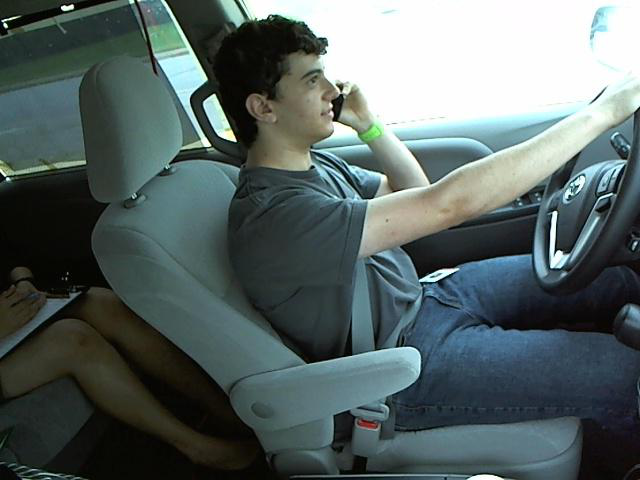

In [19]:
from PIL import Image
Image.open(test_path + filenames[4])

# Save Kaggle Submission File

In [37]:
# Must be in form of [test_img.jpg,c0_prob,c1_prob,...,c9_prob]
idx = filenames[0].find("img")
filenames2 = np.array([f[idx:] for f in filenames])
clipped_preds = preds.clip(min=0.05, max=0.95)


In [45]:
subm = np.concatenate([filenames2, clipped_preds])

ValueError: all the input arrays must have same number of dimensions

In [49]:
subm = np.empty(shape=(10,11))
subm[:,0] = filenames2

ValueError: could not convert string to float: img_38791.jpg

In [26]:
s = 'unknown/img_81596.jpg'
s.find("img")

8

In [28]:
filenames2 = np.array(f[f.find("img"):] for f in filenames)

In [29]:
filenames2

array(<generator object <genexpr> at 0x7f477eb139b0>, dtype=object)

In [31]:
np.array([(f[8:]) for f in filenames])

array(['img_81596.jpg', 'img_1460.jpg', 'img_817.jpg', 'img_58462.jpg',
       'img_68152.jpg', 'img_50382.jpg', 'img_41467.jpg', 'img_12660.jpg',
       'img_91847.jpg', 'img_38791.jpg'], 
      dtype='|S13')

In [35]:
idx = filenames[0].find("img")
filenames2 = np.array([f[idx:] for f in filenames])

In [36]:
filenames2

array(['img_81596.jpg', 'img_1460.jpg', 'img_817.jpg', 'img_58462.jpg',
       'img_68152.jpg', 'img_50382.jpg', 'img_41467.jpg', 'img_12660.jpg',
       'img_91847.jpg', 'img_38791.jpg'], 
      dtype='|S13')